# Multioutput Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib as pl
import os

import gumbi as gmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Use gumbi's plotting defaults for stylistic consistency, good dataviz practice, and aesthetics. Use `gmb.style.default` if you don't have the Futura font installed.

In [2]:
plt.style.use(gmb.style.futura)

## Setup


Load in wide-form data and store as a DataSet. We must specify which columns are considered "outputs",
and additionally we may indicate which input and output variables should be treated as log-normal or logit-normal.

In [3]:
df = pd.read_pickle(gmb.data.example_dataset)
df = df[(df.Name == 'binary-pollen') & (df.Color == 'cyan') & (df.Metric == 'mean')]
outputs=['a', 'b', 'c', 'd', 'e', 'f']
log_vars=['Y', 'b', 'c', 'd', 'f']
logit_vars=['X', 'e']
ds = gmb.DataSet(df, outputs=outputs, log_vars=log_vars,logit_vars=logit_vars)
ds

DataSet:
	wide: [14 rows x 18 columns]
	tidy: [84 rows x 14 columns]
	outputs: ['a', 'b', 'c', 'd', 'e', 'f']
	inputs: ['Code', 'Position', 'Color', 'Z', 'lg10_Z', 'Name', 'Left', 'Right', 'Pair', 'Y', 'X', 'Metric']

## Train Model 


Train a multioutput GP on five amplification parameters, using an RBF + linear kernel on `lg10_Z` to
capture continuous variation along with a coregionalization kernel to allow for correlated but distinct behavior in
both the mean and noise across the parameters.

In [4]:
fit_params = ['a', 'b', 'c', 'd', 'e']
gp = gmb.GP(ds, outputs=fit_params)
n_p = len(fit_params)
gp.fit(continuous_dims='lg10_Z', linear_dims='lg10_Z');

## Marginal Parameter Predictions

Predict each parameter individually, allowing us to ensure the marginal uncertainty is calibrated correctly.

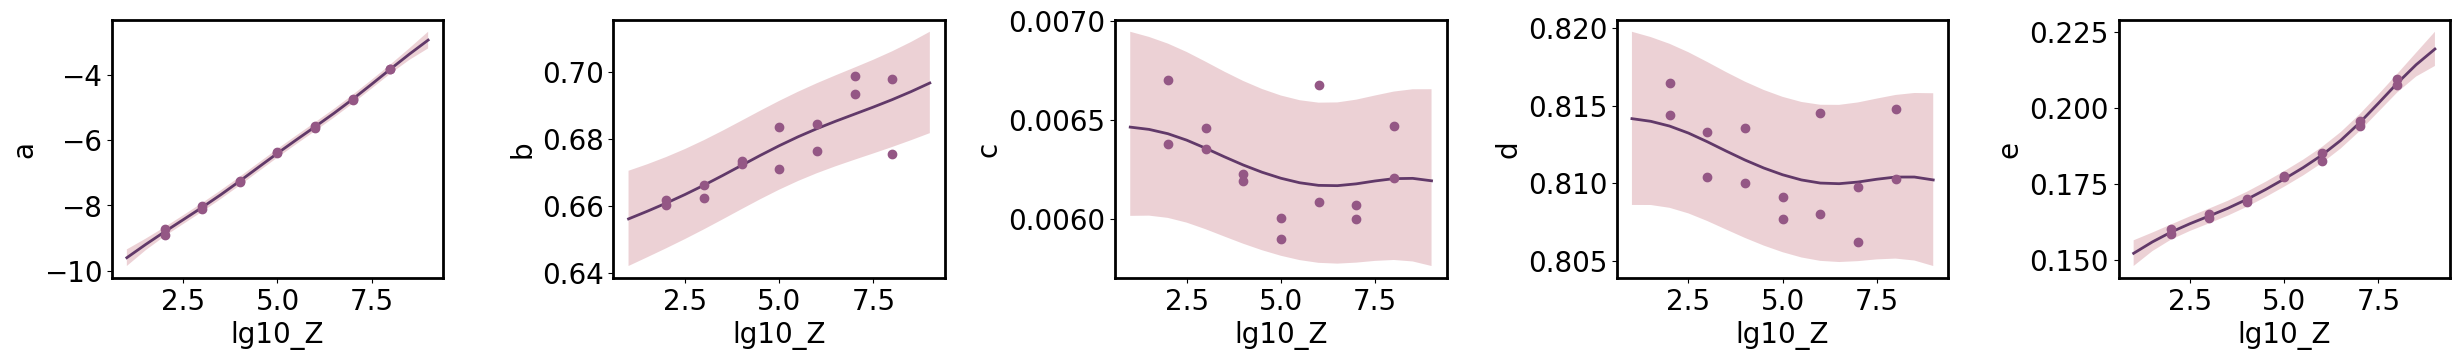

In [5]:
limits = gp.parray(lg10_Z=[1, 9])
x_pa = gp.prepare_grid(limits=limits, resolution=17)

axs = plt.subplots(1, n_p, figsize=(n_p * 5, 4))[1]

for ax, param in zip(np.atleast_1d(axs), fit_params):
    gp.predict_grid(output=param)

    y_upa = gp.predictions

    gmb.ParrayPlotter(x_pa, y_upa).plot(ax=ax)

    param_data = ds.tidy[(ds.tidy.Metric == 'mean') & (ds.tidy.Variable == param)]
    x = gp.parray(lg10_Z=param_data['lg10_Z'])
    y = param_data['Value']
    ax.plot(x, y, 'o', color=sns.cubehelix_palette()[-3])

plt.tight_layout()

## Correlated Parameter Predictions

Make joint predictions for all parameters, returning an MVUncertainParameterArray.

In [6]:
gp.prepare_grid(limits=gp.parray(lg10_Z=[1, 9]), resolution=5)
gp.predict_grid();

x_pa = gp.predictions_X
mvup = gp.predictions
mvup

('a', 'b', 'c', 'd', 'e')['μ', 'σ2']: [((-9.59442479, 0.65605058, 0.00646403, 0.81416271, 0.15214448), (0.01676639, 1.22016392e-04, 0.00134064, 1.22105406e-05, 2.80013388e-04))
 ((-8.05656298, 0.66609041, 0.00635764, 0.81267686, 0.16440518), (0.00462947, 1.03825281e-04, 0.00114775, 1.03319592e-05, 8.16338238e-05))
 ((-6.40414117, 0.67787309, 0.00620618, 0.8105507 , 0.17662809), (0.00455407, 9.92785623e-05, 0.00110227, 9.91092000e-06, 8.03754540e-05))
 ((-4.75033515, 0.68729924, 0.00617787, 0.81008143, 0.19510875), (0.00462973, 1.04073081e-04, 0.00115023, 1.03548470e-05, 8.16411508e-05))
 ((-2.94787273, 0.69658766, 0.00619329, 0.81021742, 0.21940875), (0.01685376, 1.22594426e-04, 0.00134647, 1.22658105e-05, 2.81471085e-04))]

Sample from the joint distribution at each concentration to inspect the correlations between parameters across concentrations.

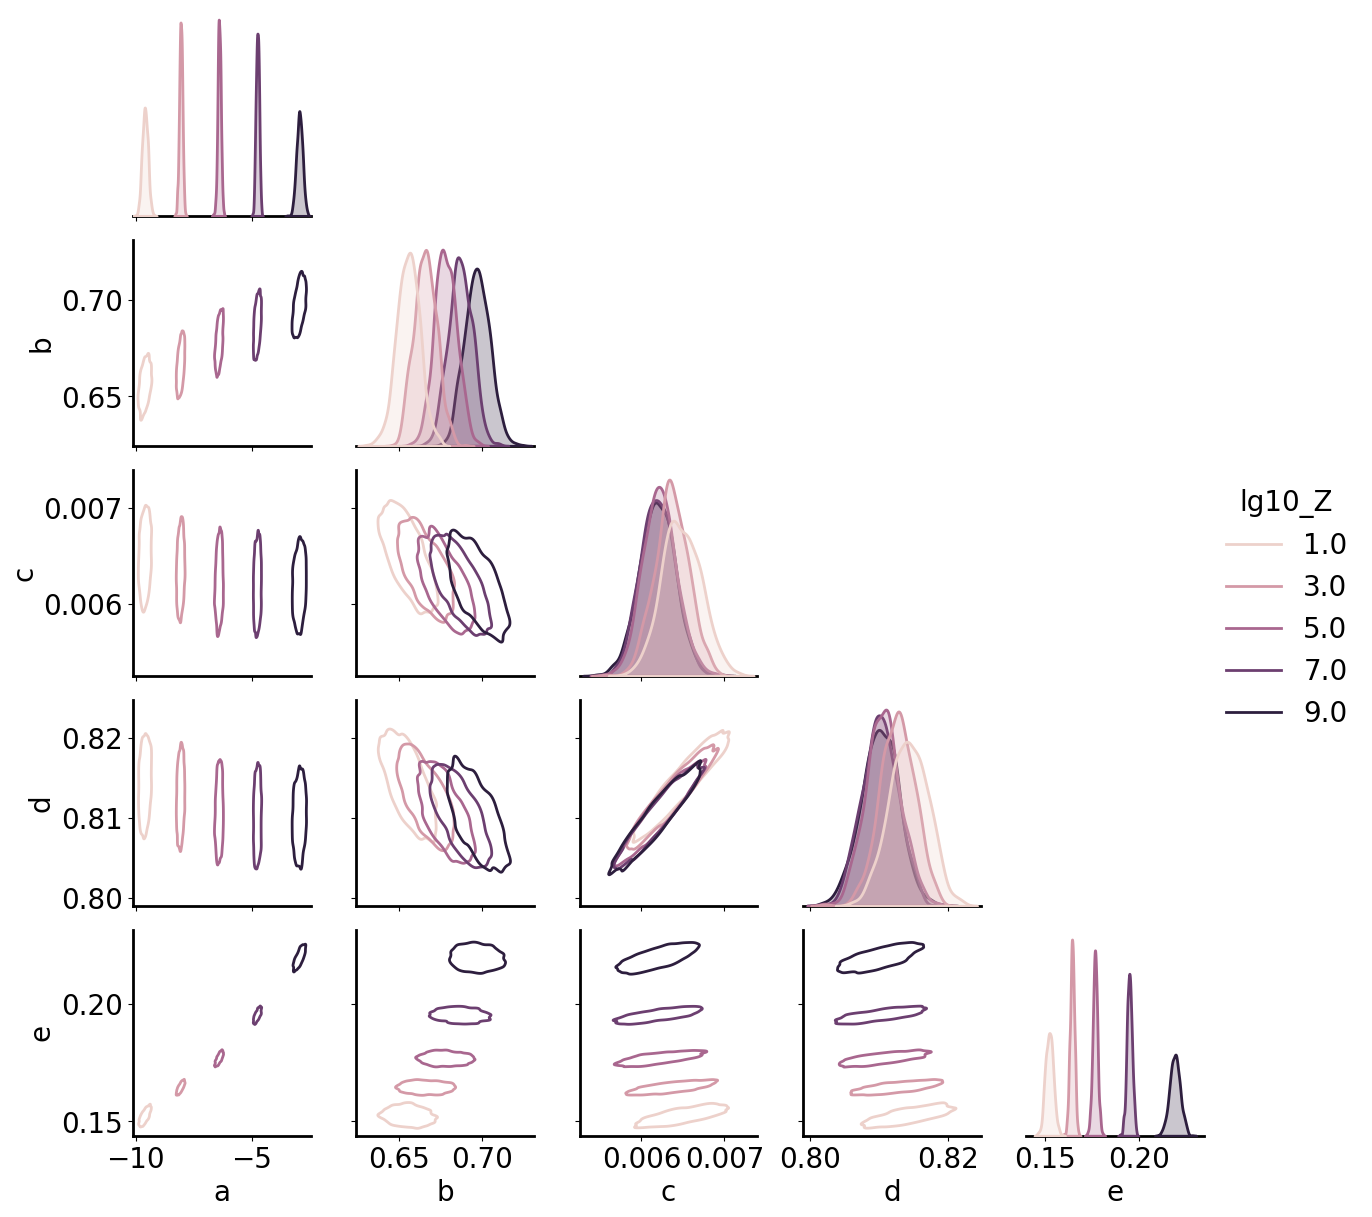

In [7]:
samples_df = pd.concat(
    [pd.DataFrame(point.dist.rvs(1000, random_state=i).as_dict()).assign(lg10_Z=copies.values()) for i, (point, copies) in enumerate(zip(mvup, x_pa))],
    ignore_index=True)

sns.pairplot(samples_df, hue='lg10_Z', kind='kde', corner=True, plot_kws={'levels': 1});